<a href="https://colab.research.google.com/github/hanyG175/machine-learning/blob/main/Plant-Disease-Detection-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
import shutil
import logging
import sys
from pathlib import Path
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import psutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Import PIL for image processing (needed for image validation)
from PIL import Image

In [ ]:
# 1. Mount Google Drive and Unzip Dataset (Colab specific)
# ---------------------------
# Only if using Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Unzip the dataset from Google Drive to local directory
except ImportError:
    print("Not running in Google Colab, skipping drive mount and unzip.")

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Tomato leaf blight/leaf blight1302_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1303_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1304_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1305_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1306_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1307_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1308_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1309_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight130_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1310_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1311_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1312_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1313_.jpg  
  inflating: /

In [ ]:
!unzip /content/drive/MyDrive/datasets/crop-pest-and-disease-detection.zip -d /content/dataset/

In [3]:
# 2. Set Global Parameters and Random Seeds
# ---------------------------
DATA_PATH = "dataset/"        # Original dataset directory
TEST_DATA_PATH = "test_data_path"  # Directory to store test images
BALANCED_PATH = "balanced_dataset"  # Directory for balanced training data

IMG_SIZE_ORIG = (224, 224)  # Original image size (used for cleaning)
IMG_HEIGHT = 128          # Model input height (for training)
IMG_WIDTH = 128           # Model input width (for training)
BATCH_SIZE = 64
EPOCHS = 10
VALIDATION_SPLIT = 0.2

# seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 3. Define Utility Functions for Dataset Cleaning
# ---------------------------
def is_valid_image(file_path):
        """
        Validate if an image is readable and not corrupted
        """
        try:
            with Image.open(file_path) as img:
                img.verify()
                # Additional check to ensure image can be loaded
                test_img = Image.open(file_path)
                test_img.load()
            return True
        except Exception as e:
            print(f"Corrupted image detected: {file_path}")
            print(f"Error: {e}")
            return False

def clean_dataset(dataset_path):
    """
    Thoroughly clean dataset by removing corrupted images
    """
    total_images = 0
    removed_images = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                total_images += 1

                # Try reading image, remove if corrupted
                if not is_valid_image(file_path):
                    os.remove(file_path)
                    removed_images += 1

    print(f"Total images scanned: {total_images}")
    print(f"Corrupted images removed: {removed_images}")

# Clean the dataset by removing corrupted images
clean_dataset(DATA_PATH)

In [5]:
# 4. Split the Dataset into Training/Validation and Test Sets
# ---------------------------
# Ensure test directory exists
os.makedirs(TEST_DATA_PATH, exist_ok=True)

# For each class directory in the dataset, split images and move a portion to test set.
classes = os.listdir(DATA_PATH)
for class_name in classes:
    class_dir = os.path.join(DATA_PATH, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        # Split: 15% of images go to test set
        train_val, test = train_test_split(images, test_size=0.15, random_state=42)

        # Create test directory for the class
        test_class_path = os.path.join(TEST_DATA_PATH, class_name)
        os.makedirs(test_class_path, exist_ok=True)

        # Move test images to the test directory
        for image in test:
            shutil.move(os.path.join(class_dir, image), os.path.join(test_class_path, image))

In [6]:
# Display class distribution after test split
class_counts = Counter()
for class_dir in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, class_dir)
    if os.path.isdir(class_path):
        class_counts[class_dir] = len(os.listdir(class_path))

print("Class Distribution after test split:")
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {count}")

Class Distribution after test split:
Tomato septoria leaf spot: 2331
Cassava bacterial blight: 2221
Cashew anthracnose: 1469
Cashew red rust: 1429
Cassava brown spot: 1258
Cashew leaf miner: 1171
Cashew healthy: 1162
Tomato leaf blight: 1094
Maize leaf spot: 1053
Cassava mosaic: 1024
Cassava healthy: 1014
Cassava green mite: 862
Maize leaf blight: 841
Maize streak virus: 820
Maize leaf beetle: 793
Tomato verticulium wilt: 656
Maize grasshoper: 572
Tomato leaf curl: 434
Tomato healthy: 396
Cashew gumosis: 333
Maize fall armyworm: 242
Maize healthy: 173


In [7]:
# 5. Define the Dataset Balancer Class
# ---------------------------
class DatasetBalancer:
    """
    Balances the dataset by augmenting images for classes with fewer samples.

    It uses parallel processing to accelerate augmentation and copying.
    """
    def __init__(self, data_path, balanced_path, batch_size=32, max_workers=None):
        """
        Initialize the dataset balancer.

        Args:
            data_path (str): Source dataset path.
            balanced_path (str): Destination path for the balanced dataset.
            batch_size (int): Batch size for processing images.
            max_workers (int): Maximum number of parallel workers.
        """
        self.data_path = Path(data_path)
        self.balanced_path = Path(balanced_path)
        self.batch_size = batch_size
        self.max_workers = max_workers or min(32, (os.cpu_count() or 1) * 2)
        # Use up to 70% of available RAM (for reference)
        self.memory_limit = int(psutil.virtual_memory().total * 0.7)
        self.data_gen = self._create_data_generator()

    @staticmethod
    def _create_data_generator():
        """
        Create an ImageDataGenerator for data augmentation.

        Returns:
            ImageDataGenerator: Configured for augmentation.
        """
        return ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2,
            fill_mode='nearest'
        )

    def _process_image_batch(self, image_files, save_dir, augment=False):
        """
        Process a batch of images by copying or augmenting.

        Args:
            image_files (list): List of image file paths.
            save_dir (Path): Destination directory for processed images.
            augment (bool): Whether to augment the images.

        Returns:
            int: Number of images processed.
        """
        try:
            for img_file in image_files:
                if augment:
                    self._augment_and_save_image(img_file, save_dir)
                else:
                    shutil.copy2(str(img_file), str(save_dir))
            return len(image_files)
        except Exception as e:
            logging.error(f"Error processing batch: {str(e)}")
            return 0

    def _augment_and_save_image(self, source_img, save_dir):
        """
        Augment a single image and save the result.

        Args:
            source_img (Path): Source image file path.
            save_dir (Path): Directory to save the augmented image.
        """
        try:
            # Load image and convert to array
            img = tf.keras.preprocessing.image.load_img(str(source_img))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, 0)

            # Generate an augmented image and save it
            _ = next(self.data_gen.flow(
                img_array,
                batch_size=1,
                save_to_dir=str(save_dir),
                save_prefix=f'aug_{source_img.stem}',
                save_format='jpg'
            ))

            # Clear memory
            del img, img_array
            tf.keras.backend.clear_session()

        except Exception as e:
            logging.error(f"Error augmenting {source_img}: {str(e)}")

    def _process_class(self, class_name, count, target_count):
        """
        Balance a single class by copying or augmenting images.

        Args:
            class_name (str): Name of the class.
            count (int): Current number of images in the class.
            target_count (int): Desired number of images.

        Returns:
            int: Final number of images for the class.
        """
        try:
            class_dir = self.data_path / class_name
            save_dir = self.balanced_path / class_name
            save_dir.mkdir(exist_ok=True, parents=True)

            # Clear existing files in the destination directory
            for file in save_dir.glob('*'):
                file.unlink()

            images = list(class_dir.glob('*'))

            if count < target_count:
                # First, copy original images
                self._batch_process_images(images, save_dir, augment=False)
                # Determine how many augmented images are needed
                remaining = target_count - count
                # Randomly select images to augment
                source_images = [random.choice(images) for _ in range(remaining)]
                self._batch_process_images(source_images, save_dir, augment=True)
            elif count > target_count:
                # Randomly select a subset of images if there are too many
                selected_images = random.sample(images, target_count)
                self._batch_process_images(selected_images, save_dir, augment=False)
            else:
                # If exactly equal, just copy all images
                self._batch_process_images(images, save_dir, augment=False)

            return len(list(save_dir.glob('*')))
        except Exception as e:
            logging.error(f"Error processing class {class_name}: {str(e)}")
            return 0

    def _batch_process_images(self, images, save_dir, augment=False):
        """
        Process images in batches using multithreading.

        Args:
            images (list): List of image file paths.
            save_dir (Path): Destination directory.
            augment (bool): Whether to augment images.
        """
        batches = [images[i:i + self.batch_size] for i in range(0, len(images), self.batch_size)]

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            process_batch = partial(self._process_image_batch, save_dir=save_dir, augment=augment)
            futures = [executor.submit(process_batch, batch) for batch in batches]

            with tqdm(total=len(images), desc=f"Processing {'augmented' if augment else 'original'} images") as pbar:
                for future in as_completed(futures):
                    pbar.update(future.result())

    def balance_dataset(self, target_count=None):
        """
        Balance the dataset so that each class has the same number of samples.

        Args:
            target_count (int, optional): Desired number of samples per class.
                                         Defaults to the maximum samples of any class.

        Returns:
            dict: Final sample count per class.
        """
        try:
            if not self.data_path.exists():
                raise ValueError(f"Source data path does not exist: {self.data_path}")
            os.makedirs(self.balanced_path, exist_ok=True)

            # Compute the number of images per class
            class_counts = {
                class_dir.name: len(list(class_dir.glob('*')))
                for class_dir in self.data_path.iterdir() if class_dir.is_dir()
            }
            target_count = target_count or max(class_counts.values())
            logging.info(f"Balancing dataset to {target_count} samples per class")

            # Process each class in parallel
            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                futures = {
                    executor.submit(self._process_class, class_name, count, target_count): class_name
                    for class_name, count in class_counts.items()
                }
                results = {}
                for future in tqdm(as_completed(futures), total=len(futures), desc="Processing classes"):
                    class_name = futures[future]
                    try:
                        results[class_name] = future.result()
                    except Exception as e:
                        logging.error(f"Error processing class {class_name}: {str(e)}")
                        results[class_name] = 0

            logging.info("Final class distribution after balancing:")
            for class_name, count in results.items():
                logging.info(f"{class_name}: {count}")
                if count != target_count:
                    logging.warning(f"Class {class_name} ended with {count} samples instead of {target_count}")
            return results
        except Exception as e:
            logging.error(f"Error during dataset balancing: {str(e)}")
            raise

In [ ]:
# 6. Balance the Dataset
# ---------------------------
if __name__ == "__main__":
    # Balance training data (the original DATA_PATH now has training/validation images only)
    balancer = DatasetBalancer(DATA_PATH, BALANCED_PATH, batch_size=32)
    balancer.balance_dataset()

    # Count and display the balanced class distribution
    balanced_class_counts = {}
    for class_dir in os.listdir(BALANCED_PATH):
        class_path = os.path.join(BALANCED_PATH, class_dir)
        if os.path.isdir(class_path):
            balanced_class_counts[class_dir] = len(os.listdir(class_path))

    print("Balanced Class Distribution:", balanced_class_counts)

In [9]:
# 7. Set Up Data Generators for Model Training
# ---------------------------
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=10,         # Slight augmentation for training
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
# Load training data from the balanced dataset directory
train_data = train_datagen.flow_from_directory(
    BALANCED_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 41027 images belonging to 22 classes.


In [11]:
# Load validation data
val_data = train_datagen.flow_from_directory(
    BALANCED_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 10251 images belonging to 22 classes.


In [12]:
# Get class information
num_classes = len(train_data.class_indices)
class_names = list(train_data.class_indices.keys())
print(f"Found {num_classes} classes: {class_names}")

Found 22 classes: ['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']


In [13]:
# 8. Build and Compile the Model
# ---------------------------
# Option 1: Use a simple custom CNN
model = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           5,654 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,223,798 (16.11 MB)

 Trainable params: 4,223,798 (16.11 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 9. Define Callbacks and Train the Model
# ---------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 267s 405ms/step - accuracy: 0.2035 - loss: 2.5712 - val_accuracy: 0.3641 - val_loss: 2.0462 - learning_rate: 0.0010
Epoch 2/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 289s 450ms/step - accuracy: 0.4115 - loss: 1.8367 - val_accuracy: 0.4080 - val_loss: 1.9250 - learning_rate: 0.0010
Epoch 3/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 251s 391ms/step - accuracy: 0.4827 - loss: 1.5929 - val_accuracy: 0.4726 - val_loss: 1.6730 - learning_rate: 0.0010
Epoch 4/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 258s 402ms/step - accuracy: 0.5181 - loss: 1.4610 - val_accuracy: 0.5201 - val_loss: 1.5509 - learning_rate: 0.0010
Epoch 5/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 260s 405ms/step - accuracy: 0.5522 - loss: 1.3575 - val_accuracy: 0.5427 - val_loss: 1.4337 - learning_rate: 0.0010
Epoch 6/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 261s 407ms/step - accuracy: 0.5777 - loss: 1.2592 - val_accuracy: 0.5584 - val_loss: 1.4140 - learning_rate: 0.0010
Epoch 7/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 260s 406ms/step - accura

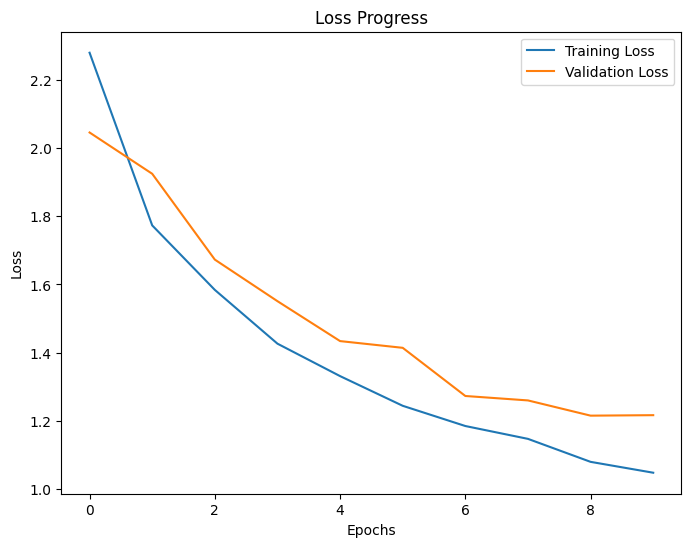

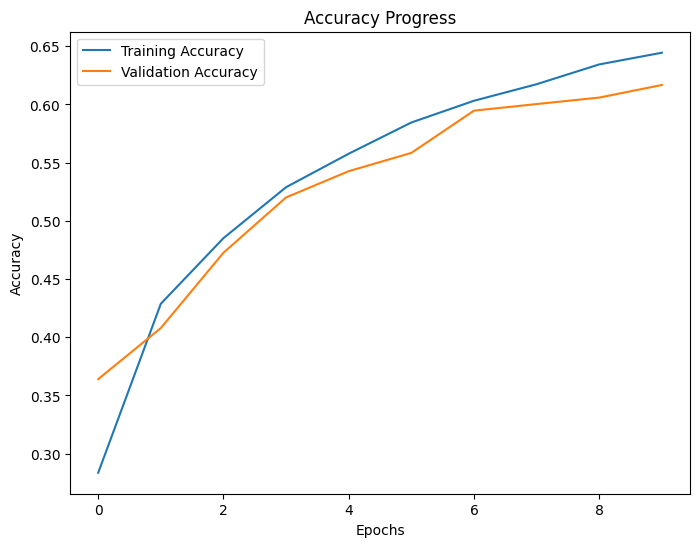

161/161 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step


In [16]:
# 10. Evaluate the Model and Save Results
# ---------------------------
# Create directory to save evaluation results
Path('evaluation_results').mkdir(exist_ok=True)

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('evaluation_results/loss_curve.png')
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('evaluation_results/accuracy_curve.png')
plt.show()

# Generate predictions on validation data for confusion matrix and report
val_predictions = model.predict(val_data)
y_pred = np.argmax(val_predictions, axis=1)
y_true = val_data.classes

# Plot and save confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('evaluation_results/confusion_matrix.png')
plt.close()

In [17]:
# Generate and save classification report
report = classification_report(y_true, y_pred, target_names=class_names)
with open('evaluation_results/classification_report.txt', 'w') as f:
    f.write(report)
print(f"\nClassification Report:\n{report}")


Classification Report:
                           precision    recall  f1-score   support

       Cashew anthracnose       0.50      0.40      0.44       466
           Cashew gumosis       0.94      0.88      0.91       466
           Cashew healthy       0.74      0.56      0.64       466
        Cashew leaf miner       0.53      0.50      0.51       466
          Cashew red rust       0.94      0.73      0.82       466
 Cassava bacterial blight       0.45      0.45      0.45       466
       Cassava brown spot       0.60      0.62      0.61       466
       Cassava green mite       0.69      0.73      0.71       466
          Cassava healthy       0.79      0.71      0.75       466
           Cassava mosaic       0.69      0.66      0.67       466
      Maize fall armyworm       0.50      0.58      0.53       465
         Maize grasshoper       0.69      0.89      0.78       466
            Maize healthy       0.56      0.93      0.70       466
        Maize leaf beetle       0.76 

In [18]:
# 11. Evaluate on Test Data and Save the Model
# ---------------------------
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate model on unseen test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 3778 images belonging to 22 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.6711 - loss: 0.9753
Test Accuracy: 66.75%


In [19]:
model.save('plant_disease_model.h5')